Encoding categorical values (such as names, addresses, but also textual data) is 
a very common problem when it comes to prepare tabular data for training ML models, 
and Skrub provides four encoders to this end: 

- `skrub.MinhashEncoder`, a simple encoder based on hashing categories.
- `skrub.GapEncoder`, which encoders strings based on latent categories estimated
from the data.
- `skrub.TextEncoder`, a language model-based encoder that uses pre-trained language
models to produce vectors for each string.
- `skrub.StringEncoder`, an encoder that vectorizes data with tf-idf and then applies
SVD to reduce the number of features.  

The objective of this post is to test the performance of each encoder on a few 
datasets in order to find out which methods should be considered in various 
circumstances. 

### Preparing the datasets
We begin by importing and preparing the datasets that should be used for the experiments:
```python
from skrub.datasets import fetch_toxicity, fetch_movielens, fetch_employee_salaries, fetch_open_payments

datasets = {}
## Open Payments (Classification)
dataset = fetch_open_payments()
X, y = dataset.X, dataset.y
y = y.map({"disallowed": 0, "allowed": 1})
datasets["Open Payments"] = (X,y,"classification")

## Toxicity (Classification)
dataset = fetch_toxicity()
X, y = dataset.X, dataset.y
X["is_toxic"] = y
y = X.pop("is_toxic").map({"Toxic": 1, "Not Toxic": 0})
datasets["Toxicity"] = (X,y, "classification")

## Movielens (Regression)
dataset = fetch_movielens()
X, y = pl.from_pandas(dataset.movies), pl.from_pandas(dataset.ratings)
X = (
    X.join(y, on="movieId")
    .group_by("movieId", "title", "genres")
    .agg(target=pl.mean("rating"))
)
y = X["target"].to_numpy()
X = X.drop("target")
datasets["Movielens"]=(X,y, "regression")

## Employee salaries (Regression)
dataset = fetch_employee_salaries()
X = pl.from_pandas(dataset.employee_salaries)
y = X["current_annual_salary"]
X = X.drop("current_annual_salary")

datasets["Employee salaries"]=(X,y, "regression")

```
### Setting up the experiments
We can test each method by building a scikit-learn pipeline for each categorical encoder,
using the default `HistGradientBoostingClassifier` and `HistGradientBoostingRegressor`
as prediction model.

Them, we use the `cross_validate` function to track the fit and score time, as well as the
prediction performance of each pipeline over different splits.
For simplicity, we are not performing hyperparameter optimization for either the 
categorical encoder or the learner.  

```python

from matplotlib import pyplot as plt
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
import polars as pl
from skrub import (
    GapEncoder,
    MinHashEncoder,
    StringEncoder,
    TableVectorizer,
    TextEncoder,
)

def run_experiments(X, y, task, dataset_name):
    if task == "regression":
        model = HistGradientBoostingRegressor()
        scoring = "r2"
    else:
        model = HistGradientBoostingClassifier()
        scoring = "roc_auc"

    results = []

    # For each encoder, create a new pipeline
    gap_pipe = make_pipeline(
        TableVectorizer(high_cardinality=GapEncoder(n_components=30)), model
    )
    minhash_pipe = make_pipeline(
        TableVectorizer(high_cardinality=MinHashEncoder(n_components=30)), model
    )
    text_encoder = TextEncoder(
        "sentence-transformers/paraphrase-albert-small-v2",
        device="cpu",
    )
    text_encoder_pipe = make_pipeline(
        TableVectorizer(high_cardinality=text_encoder),
        model,
    )
    string_encoder = StringEncoder(ngram_range=(3, 4), analyzer="char_wb")
    string_encoder_pipe = make_pipeline(
        TableVectorizer(high_cardinality=string_encoder),
        model,
    )

    pipes = [
        ("GapEncoder", gap_pipe),
        ("MinHashEncoder", minhash_pipe),
        ("TextEncoder", text_encoder_pipe),
        ("StringEncoder", string_encoder_pipe),
    ]

    for name, p in pipes:
        cross_validate_results = cross_validate(p, X, y, scoring=scoring)
        results.append(
            pl.DataFrame(add_results(name, dataset_name, cross_validate_results))
        )
    df_results = pl.concat(results).with_columns(task=pl.lit(task))
    return df_results

```
### Running the experiments and saving the results
Finally, I ran the crossvalidation step for each encoder on all dataset and I 
recorded the files in a csv file. This step took quite some time, and was done
offline in a separater script.  

```python
all_results = []
for dataset_name,v in datasets.items():
    X, y, task = v
    results = run_experiments(X, y, task, dataset_name) 
    all_results.append(results)
df_all_results = pl.concat(all_results)
df_all_results.write_csv("results-encoder_benchmark.csv")
```

### Plotting the results
Now, we can load the results and start plotting the results. We first split the 
results in two subtables based on the specific task (either regression or 
classification), to avoid mixing metrics. 

In [4]:
import polars as pl
import matplotlib.pyplot as plt
df = pl.read_csv("results-encoder_benchmark.csv")
df_regression = df.filter(task="regression")
df_classification = df.filter(task="classification")

To see the tradeoff between fit time and prediction performance, we use a 
scatterplot with error bars to find the average performance and run time for each
method. 

Then, we can plot the prediction performance as a function of the run time. 

In [ ]:
def plot_scatter_errorbar(df, ylabel, sharey=False, suptitle=""):
    # Fixing the colors for each cluster of points and the error bars
    tab10_colors = plt.get_cmap('tab10').colors
    colors = dict(zip(df["estimator"].unique().sort().to_list(),tab10_colors[:4]))
    fig, axs = plt.subplots(1,2, sharey=sharey, layout="constrained", figsize=(8,3))
    # Each dataset gets a subplot
    for idx, (dataset, g) in enumerate(df.group_by("dataset")):
        ax=axs[idx]
        # Each estimator is plotted separately as a cluster of points
        for estimator, gdf in g.group_by("estimator"):
            estim = estimator[0]
            color = colors[estim]
            x = gdf["fit_time"].to_numpy()
            y = gdf["test_score"].to_numpy()
            label = estim if idx == 0 else "_" + estim
            ax.scatter(x=x, y=y, label=label, color=color)
            
            # find the mean and the error bars 
            xerr_mean = gdf["fit_time"].mean()
            yerr_mean = gdf["test_score"].mean()
            x_err = gdf["fit_time"].std()
            y_err = gdf["test_score"].std()
            # plot the error bars
            ax.errorbar(xerr_mean, yerr_mean, xerr=x_err, fmt="none", color=color)
            ax.errorbar(xerr_mean, yerr_mean, yerr=y_err, fmt="none", color=color)
            
        ax.set_title(dataset[0])
        ax.set_xlabel("Fit time (s)")
        ax.set_ylabel(ylabel)
        ax.set_xscale("log")
    fig.suptitle(suptitle)
    fig.legend(loc="lower center", ncols=2)

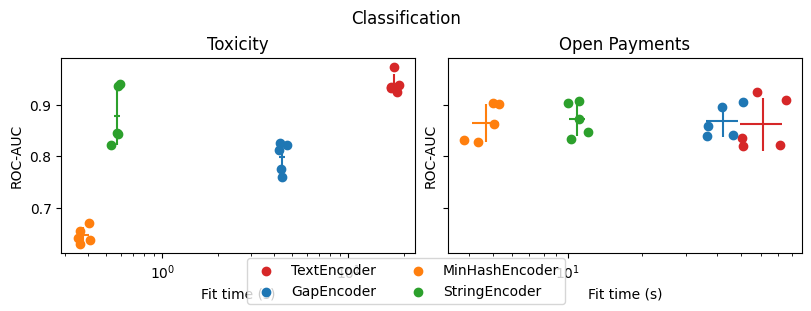

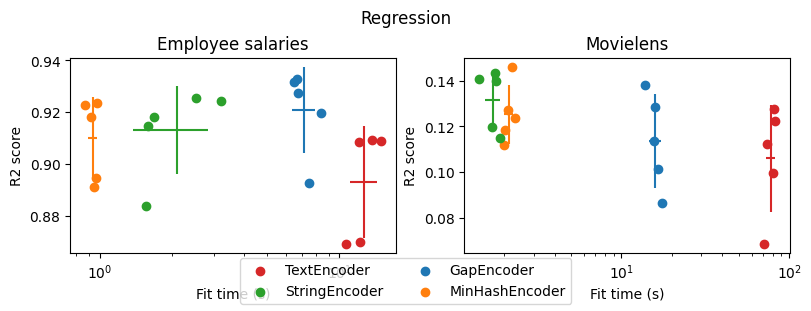

In [37]:
plot_scatter_errorbar(df_classification, "ROC-AUC", sharey=True, suptitle="Classification")
plot_scatter_errorbar(df_regression, "R2 score", sharey=False, suptitle="Regression")

The prediction performance is fairly consistent across methods, although this 
depends on the table under observation. `MinhashEncoder` and `StringEncoder` are 
consistently faster than the alternatives.  
`TextEncoder` is always much slower than the other methods, however it must be noted
that this example was run on a CPU, rather than a much faster GPU. 

To have a better idea of why some methods may outperform others, we should take a 
look at the actual tables. We can do so very easily thanks to the skrub `TableReport`
object.


In [38]:
from skrub import TableReport
from skrub.datasets import fetch_toxicity, fetch_movielens, fetch_employee_salaries, fetch_open_payments

In [46]:
# OPEN PAYMENTS
dataset = fetch_open_payments()
X, y = dataset.X, dataset.y
TableReport(X)

Processing column   5 / 5


,,,,,


In [47]:
# TOXICITY
dataset = fetch_toxicity()
X, y = dataset.X, dataset.y
TableReport(X)

Processing column   1 / 1


<TableReport: use .open() to display>

In [48]:
# MOVIELENS
dataset = fetch_movielens()
X, y = pl.from_pandas(dataset.movies), pl.from_pandas(dataset.ratings)
X = (
    X.join(y, on="movieId")
    .group_by("movieId", "title", "genres")
    .agg(target=pl.mean("rating"))
)
X = X.drop("target")

TableReport(X)


Processing column   3 / 3


<TableReport: use .open() to display>

In [49]:
# EMPLOYEE SALARIES
dataset = fetch_employee_salaries()
X = pl.from_pandas(dataset.employee_salaries)
X = X.drop("current_annual_salary")
TableReport(X)


Processing column   8 / 8


,,,,,,,


All datasets include high cardinality features which must be encoded using one of 
the skrub Encoders. The Toxicity dataset is different from the others in that it 
involves free-flowing text as tweets, while all other tables include a (possibly)
large number of unique categories. 

This explains why the `TextEncoder` is so much better than the other encoders on
Toxicity, while its performance on the other datasets is more in line with the others.

On the other hand, the `StringEncoder`shows a strong performance in all cases, 
while being top-2 on average for the fit time.

### In summary
The skrub `TableVectorizer` transforms categorical features into numbers so that
ML models can make better use of the information they contain. 
The `StringEncoder` can be considered the best all-rounder, being fast to train
in most cases, while maintaining strong performance in general. The `TextEncoder`
shines when textual data is available as it can make full use of the pre-trained
language models it relies on. The `MinHashEncoder` and the `GapEncoder` are more
specialized models that may work better than the alternatives in specific 
circumstances. 